# Computer vision: dog, cat or frog?

## Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

import time
import datetime
import copy

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

## Data preparation

In [2]:
# generic
batch_size = 128
num_workers = 2

# data transformations
m = np.array([0.485, 0.456, 0.406])
s = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(m, s)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(m, s)
    ]),
}

print("Initializing datasets and dataloaders...")

# data path
DATA_PATH = './data_folder'

# create training and validation datasets
cifar10 = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=data_transforms['train'])
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=data_transforms['val'])

# obtain reduced datasets (dogs, cats and frogs)
label_map = {3: 0, 5: 1, 6: 2}
class_names = ['cat', 'dog', 'frog']
n_classes = len(class_names)

cifar3 = [(img, label_map[label]) for img, label in cifar10 if label in [3, 5, 6]]
cifar3_val = [(img, label_map[label]) for img, label in cifar10_val if label in [3, 5, 6]]
image_datasets = {'train': cifar3, 'val':cifar3_val}

# create training and validation dataloaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                   shuffle=True, num_workers=num_workers) for x in ['train', 'val']}

Initializing datasets and dataloaders...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data_folder/cifar-10-python.tar.gz to ./data_folder
Files already downloaded and verified


In [3]:
# get device
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Device: {device}.")

Device: cuda.


## Look at some images

In [4]:
def show(imgs):
    mean = m
    std = s
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(figsize = (10,10), ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = img.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
imgs, labs = next(iter(data_loaders['train']))
imgs = imgs[0:4, :, :, :]

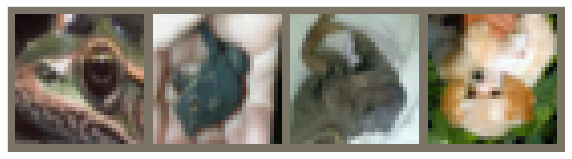

In [6]:
imgs_grid = make_grid(imgs)
show(imgs_grid)

## Helper functions

In [7]:
def check_params(model, verbose=False):

    '''Inspect model parameters'''

    modname = model.__class__.__name__
    print(f'Model: {modname}')

    tot = []
    for name, param in model.named_parameters():
        if param.requires_grad==True:
            tot.append(param.numel())
            if verbose:
                print(f'\t{name:<14}--> size: {param.numel():6}, shape: {param.shape}')
    
    print(f'Total number of parameters: {sum(tot)}')


def plot_history(log, fig_height=6):

    '''Given metric history for a model, plots metrics on epochs'''

    fig, axs = plt.subplots(ncols=2, figsize=(1.618*fig_height*2, fig_height))
    #sns.set_style('darkgrid')

    for i, ax in enumerate(axs.ravel()):

        metric = 'loss' if i==0 else 'acc'
        metric_name = 'cross entropy' if i==0 else 'accuracy'
        yt = np.array(log[metric]['train'])
        yv = np.array(log[metric]['val'])
        x = list(range(1, len(yv)+1))
        plotdata = pd.melt(pd.DataFrame({'epoch':x, 'train':yt, 'val':yv}), id_vars='epoch', value_name=metric, var_name='phase')
        
        sns.lineplot(ax=ax, x='epoch', y=metric, hue='phase', data=plotdata, palette=sns.color_palette('Dark2')[0:2])
        ax.set_xlabel('epochs',size=15)
        ax.set_ylabel(metric_name ,size=15)

    fig.suptitle(f'{model.__class__.__name__}', fontsize=18)


def compare_models(models_dict, phase='val', metric='acc', fig_height = 6):

    '''
    Given a model dictionary with model and logs, plot metric of interest
    on epochs for every model
    '''

    d = pd.DataFrame()
    for k, v in models_dict.items():
        d[str(k)] = v[1][metric][phase]

    d['epoch'] = list(range(1, len(d)+1))
    metric_name = 'cross entropy' if metric=='loss' else 'accuracy'
    plotdata = pd.melt(d, id_vars='epoch', value_name=metric_name, var_name='model')
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(1.618*fig_height, fig_height))
    #sns.set_style('darkgrid')
    sns.lineplot(ax=ax, x='epoch', y=metric_name,
                 hue='model', data=plotdata,
                 palette=sns.color_palette('Dark2')[0:(len(d.columns)-1)])
    ax.set_xlabel('epochs',size=15)
    ax.set_ylabel(metric_name ,size=15)
    ax.set_title('Model comparison',size=18)

In [8]:
models_dict = dict()

## Analysis

### Define nets

In [9]:
class VanillaNet(nn.Module):
    
    '''
    Combines convolutions and pooling to learn spatial features from images.
    This way, we achieve local operation on neighborhoods, translation 
    invariance, fewer parameters in the model.
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1//2, kernel_size=3, padding=1))
        
        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class DropoutNet(nn.Module):

    '''
    Uses Dropout (2014), a procedure which amounts to zero out a proportion of 
    outputs after activation functions during training.
    Avoids overfitting and is somewhat similar to regularization/weight decay
    or data augmentation. Dropout2d zeroes 2D channels.
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1//2, kernel_size=3, padding=1))
        
        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.dropout(F.max_pool2d(out, 2), p=0.4)
        out = torch.relu(self.conv2(out))
        out = F.dropout(F.max_pool2d(out, 2), p=0.4)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


class BatchnormNet(nn.Module):

    '''
    Uses Batch normalization (2015), which standardizes inputs using running 
    batch mean and std during training and uses whole data estimates during
    inference (inputs still need to be standardized beforehand).
    Acts as a regularizer (so is an alternative to dropout) and allows for
    greater learning rates
    '''

    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # convolution + batchnorm + pooling
        self.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=n_chans1, kernel_size=3, padding=1))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans1))
        self.add_module('conv2', nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1 // 2, kernel_size=3, padding=1))
        self.add_module('bn2', nn.BatchNorm2d(num_features=n_chans1 // 2))

        # linear
        self.add_module('fc1', nn.Linear(n_chans1//2 * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.bn2(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, self.n_chans1//2 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Define training function

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    modelname = model.__class__.__name__
    start = time.time()

    loss_history = {'train': [], 'val': []}
    acc_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f'Training model {modelname}')
    print(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"), '\n')
    print('*'*120, '\n')

    for epoch in range(1, num_epochs+1):
        
        start2 = time.time()
        epoch_loss_dict = dict()
        epoch_acc_dict = dict()

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            # metrics 
            running_loss = 0.0
            running_corrects = 0

            # iterate over batches
            for inputs, labels in dataloaders[phase]:

                # get data to the right device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track gradient history only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # if training: backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # record epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            epoch_loss_dict[phase] = epoch_loss
            epoch_acc_dict[phase] = epoch_acc

            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc.cpu().item())

            # check for best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # end of epoch
        nowtime = datetime.datetime.now().strftime("%H:%M:%S")
        if epoch < 4 or epoch % 10 == 0:
            msg_loss = f"train_loss: {epoch_loss_dict['train']:.4f}  valid_loss: {epoch_loss_dict['val']:.4f}"
            msg_acc = f"train_acc: {epoch_acc_dict['train']:.4f}  valid_acc: {epoch_acc_dict['val']:.4f}"
            print(f'epoch {epoch}/{num_epochs}\t{msg_loss}  {msg_acc}   {nowtime}')

    # end of training
    time_elapsed = time.time() - start
    print()
    print('*'*120)
    print(f'\n{modelname} training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    log = {'loss': loss_history, 'acc': acc_history}

    return model, log

### Train the models

In [11]:
num_epochs = 100

**VanillaNet**

In [12]:
print('Getting training setup...\n')

model = VanillaNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: VanillaNet
Total number of parameters: 18123


In [13]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model VanillaNet
14/10/2022 16:48:18 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0170  valid_loss: 0.9249  train_acc: 0.4723  valid_acc: 0.5490   16:48:25
epoch 2/100	train_loss: 0.9057  valid_loss: 0.8542  train_acc: 0.5679  valid_acc: 0.5843   16:48:26
epoch 3/100	train_loss: 0.8560  valid_loss: 0.8095  train_acc: 0.5869  valid_acc: 0.6023   16:48:27
epoch 10/100	train_loss: 0.7397  valid_loss: 0.7544  train_acc: 0.6537  valid_acc: 0.6330   16:48:34
epoch 20/100	train_loss: 0.6687  valid_loss: 0.6840  train_acc: 0.6903  valid_acc: 0.6760   16:48:44
epoch 30/100	train_loss: 0.6309  valid_loss: 0.6771  train_acc: 0.7153  valid_acc: 0.6800   16:48:54
epoch 40/100	train_loss: 0.5976  valid_loss: 0.6722  train_acc: 0.7318  valid_acc: 0.6810   16:49:04
epoch 50/100	train_loss: 0.5683  valid_loss: 0.6731  train_acc: 0.7502  valid_acc: 0.6860   16:49:15
epoch 60/100	train_loss:

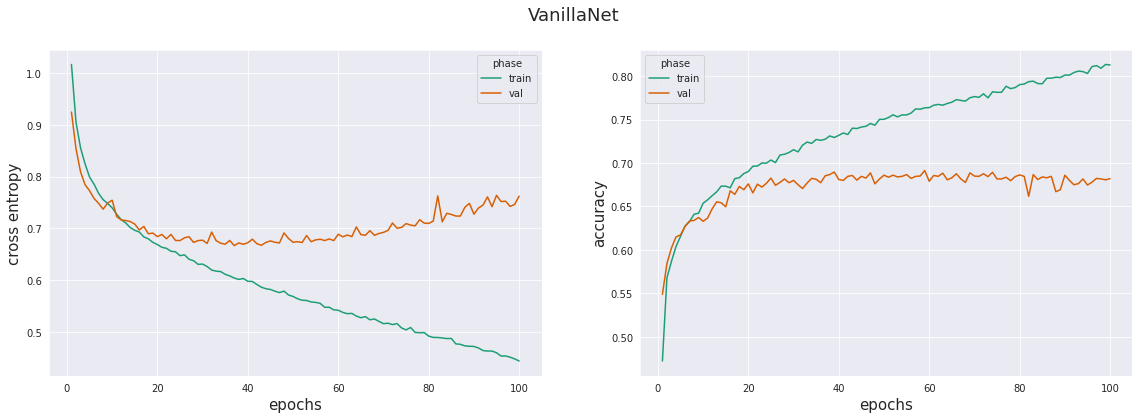

In [14]:
plot_history(log)

In [15]:
models_dict['VanillaNet'] = model, log

**DropoutNet**

In [16]:
print('Getting training setup...\n')

model = DropoutNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: DropoutNet
Total number of parameters: 18123


In [17]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model DropoutNet
14/10/2022 16:50:06 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0600  valid_loss: 0.9803  train_acc: 0.4336  valid_acc: 0.5107   16:50:08
epoch 2/100	train_loss: 0.9455  valid_loss: 0.8890  train_acc: 0.5345  valid_acc: 0.5570   16:50:09
epoch 3/100	train_loss: 0.8948  valid_loss: 0.8529  train_acc: 0.5612  valid_acc: 0.5817   16:50:10
epoch 10/100	train_loss: 0.7623  valid_loss: 0.7524  train_acc: 0.6328  valid_acc: 0.6307   16:50:17
epoch 20/100	train_loss: 0.7199  valid_loss: 0.7242  train_acc: 0.6605  valid_acc: 0.6580   16:50:27
epoch 30/100	train_loss: 0.7050  valid_loss: 0.7166  train_acc: 0.6682  valid_acc: 0.6557   16:50:37
epoch 40/100	train_loss: 0.6887  valid_loss: 0.7079  train_acc: 0.6768  valid_acc: 0.6643   16:50:48
epoch 50/100	train_loss: 0.6769  valid_loss: 0.7076  train_acc: 0.6877  valid_acc: 0.6683   16:50:58
epoch 60/100	train_loss:

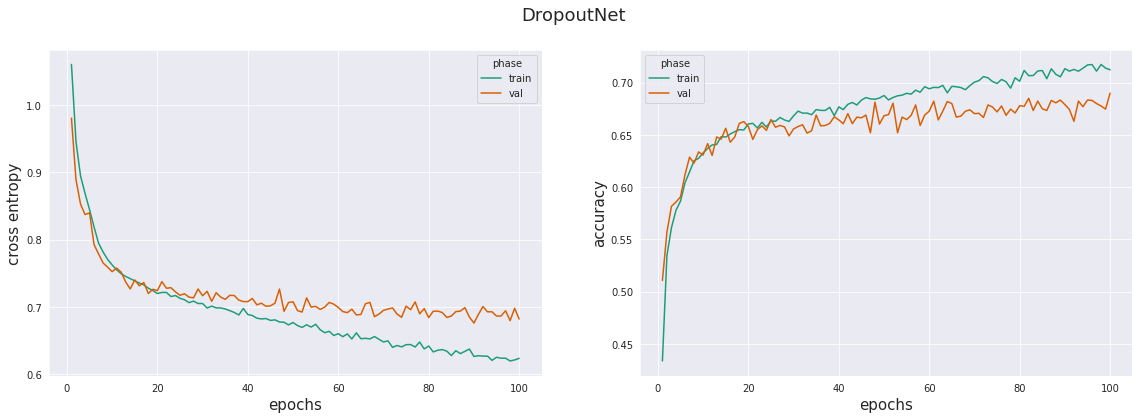

In [18]:
plot_history(log)

In [19]:
models_dict['DropoutNet'] = model, log

**BatchnormNet**

In [20]:
print('Getting training setup...\n')

model = BatchnormNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: BatchnormNet
Total number of parameters: 18171


In [21]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model BatchnormNet
14/10/2022 16:51:50 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.9568  valid_loss: 0.8376  train_acc: 0.5251  valid_acc: 0.5977   16:51:51
epoch 2/100	train_loss: 0.8053  valid_loss: 0.7611  train_acc: 0.6150  valid_acc: 0.6250   16:51:52
epoch 3/100	train_loss: 0.7488  valid_loss: 0.7276  train_acc: 0.6458  valid_acc: 0.6557   16:51:53
epoch 10/100	train_loss: 0.6370  valid_loss: 0.6714  train_acc: 0.7087  valid_acc: 0.6857   16:52:01
epoch 20/100	train_loss: 0.5671  valid_loss: 0.6383  train_acc: 0.7532  valid_acc: 0.7110   16:52:12
epoch 30/100	train_loss: 0.5209  valid_loss: 0.6307  train_acc: 0.7721  valid_acc: 0.7110   16:52:23
epoch 40/100	train_loss: 0.4812  valid_loss: 0.6439  train_acc: 0.7957  valid_acc: 0.7163   16:52:34
epoch 50/100	train_loss: 0.4445  valid_loss: 0.6668  train_acc: 0.8103  valid_acc: 0.7110   16:52:44
epoch 60/100	train_los

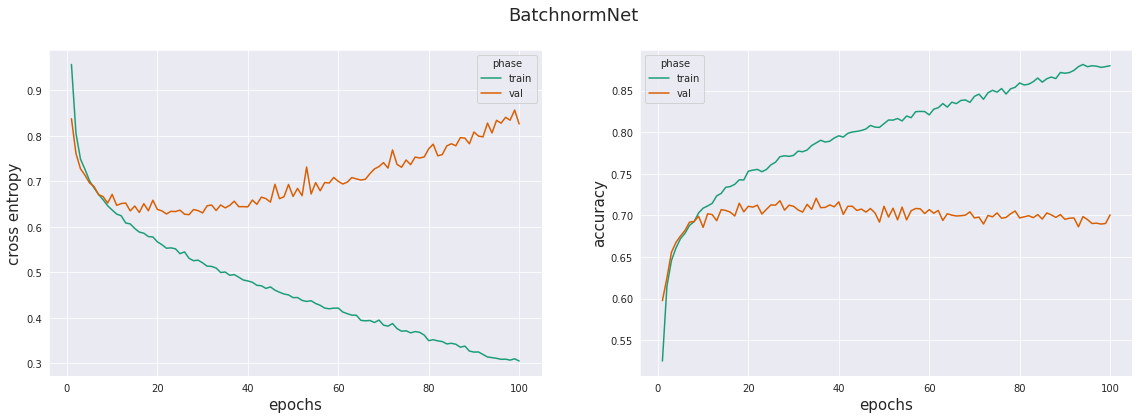

In [22]:
plot_history(log)

In [23]:
models_dict['BatchnormNet'] = model, log

**ConvNet**

In [24]:
class ConvBlock(nn.Module):

    '''Convolution block'''

    def __init__(self, in_chans, out_chans, kernel_size=3, padding=1,):
        super(ConvBlock, self).__init__()
        
        # convolution + batchnorm + dropout
        self.add_module('conv', nn.Conv2d(in_chans, out_chans,
                                          kernel_size=kernel_size, padding=padding, bias=False))
        self.add_module('bn', nn.BatchNorm2d(num_features=out_chans))

        # parameter initialization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bn.weight, 0.5)
        torch.nn.init.zeros_(self.bn.bias)
    
    def forward(self, x):
        out = F.dropout2d(torch.relu(self.bn(self.conv(x))), p=0.2)
        return out

class ConvNet(nn.Module):

    '''Combines convolutions, pooling, batch normalization and dropout'''

    def __init__(self, n_chans=16, n_blocks=2):
        super().__init__()

        self.n_chans = n_chans
        
        # first convolution
        self.add_module('conv1', ConvBlock(3, out_chans=n_chans))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans))

        # intermediate convolution blocks
        self.add_module('convblocks',
                        nn.Sequential(*(n_blocks * [ConvBlock(in_chans=n_chans, out_chans=n_chans)])))

        # linear
        self.add_module('fc1', nn.Linear(n_chans * 8 * 8, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):

        out = torch.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        out = F.max_pool2d(self.convblocks(out), 2)
        out = out.view(-1, self.n_chans * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
print('Getting training setup...\n')

model = ConvNet().to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: ConvNet
Total number of parameters: 35731


In [26]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model ConvNet
14/10/2022 16:53:38 

************************************************************************************************************************ 

epoch 1/100	train_loss: 1.0294  valid_loss: 0.9797  train_acc: 0.4627  valid_acc: 0.5147   16:53:39
epoch 2/100	train_loss: 0.9402  valid_loss: 0.9235  train_acc: 0.5434  valid_acc: 0.5653   16:53:41
epoch 3/100	train_loss: 0.9053  valid_loss: 0.9031  train_acc: 0.5576  valid_acc: 0.5633   16:53:42
epoch 10/100	train_loss: 0.8162  valid_loss: 0.8556  train_acc: 0.6106  valid_acc: 0.5887   16:53:50
epoch 20/100	train_loss: 0.7670  valid_loss: 0.8123  train_acc: 0.6419  valid_acc: 0.6307   16:54:02
epoch 30/100	train_loss: 0.7411  valid_loss: 0.8055  train_acc: 0.6576  valid_acc: 0.6187   16:54:14
epoch 40/100	train_loss: 0.7114  valid_loss: 0.7931  train_acc: 0.6739  valid_acc: 0.6397   16:54:25
epoch 50/100	train_loss: 0.6911  valid_loss: 0.7867  train_acc: 0.6839  valid_acc: 0.6413   16:54:37
epoch 60/100	train_loss: 0.

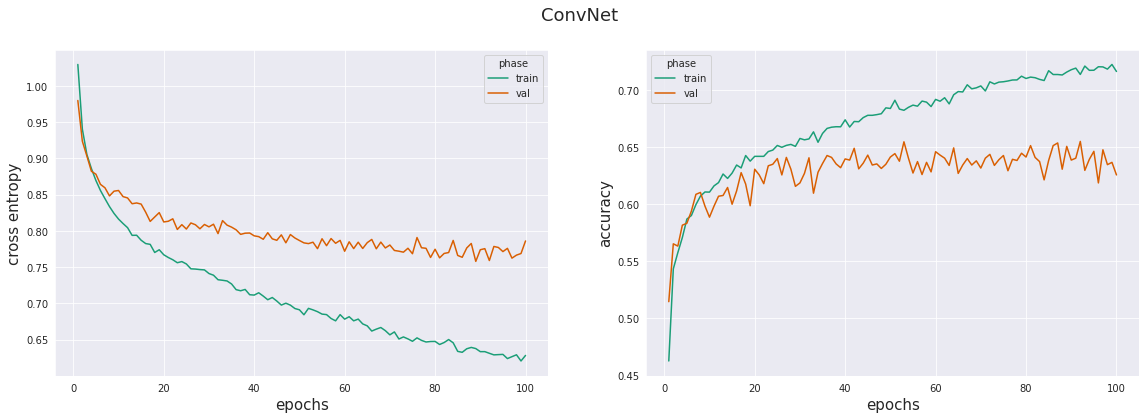

In [27]:
plot_history(log)

In [28]:
models_dict['ConvNet'] = model, log

**ResNet**

In [29]:
class ResBlock(nn.Module):

    '''ResNet intermediate block with skip connection'''

    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        # convolution + batchnorm
        self.add_module('conv', nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False))
        self.add_module('bn', nn.BatchNorm2d(num_features=n_chans))

        # parameter initialization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.bn.weight, 0.5)
        torch.nn.init.zeros_(self.bn.bias)
    
    def forward(self, x):
        out = torch.relu(self.bn(self.conv(x)))
        return out + x

class DeepResNet(nn.Module):
    
    '''
    Residual nets (2015): deep net with multiple skip connections, which 
    alleviates the vanishing gradient problem allowing for deeper nets.
    Skip connection: out = layer(x) + x
    The structure is similar to torchvision pretrained ResNet50 etc. 
    '''
    
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        
        # first convolution
        self.add_module('conv1', nn.Conv2d(3, n_chans1, kernel_size=3, padding=1))
        self.add_module('bn1', nn.BatchNorm2d(num_features=n_chans1))
        
        # resnet blocks with skip connection
        self.add_module('resblocks', nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)])))

        # linear
        self.add_module('fc1', nn.Linear(8 * 8 * n_chans1, 32))
        self.add_module('fc2', nn.Linear(32, n_classes))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
print('Getting training setup...\n')

model = DeepResNet(n_blocks=3).to(device)
check_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.CrossEntropyLoss()

Getting training setup...

Model: DeepResNet
Total number of parameters: 75907


In [31]:
model, log = train_model(model, data_loaders, loss_fn, optimizer, num_epochs=num_epochs)

Training model DeepResNet
14/10/2022 16:55:38 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.9079  valid_loss: 0.7771  train_acc: 0.5502  valid_acc: 0.6230   16:55:39
epoch 2/100	train_loss: 0.7624  valid_loss: 0.7279  train_acc: 0.6365  valid_acc: 0.6497   16:55:40
epoch 3/100	train_loss: 0.7089  valid_loss: 0.6883  train_acc: 0.6709  valid_acc: 0.6807   16:55:42
epoch 10/100	train_loss: 0.5870  valid_loss: 0.6509  train_acc: 0.7374  valid_acc: 0.6977   16:55:51
epoch 20/100	train_loss: 0.4877  valid_loss: 0.6145  train_acc: 0.7893  valid_acc: 0.7233   16:56:05
epoch 30/100	train_loss: 0.4080  valid_loss: 0.6695  train_acc: 0.8293  valid_acc: 0.7187   16:56:18
epoch 40/100	train_loss: 0.3292  valid_loss: 0.7758  train_acc: 0.8672  valid_acc: 0.7060   16:56:32
epoch 50/100	train_loss: 0.2582  valid_loss: 0.7643  train_acc: 0.9004  valid_acc: 0.7097   16:56:45
epoch 60/100	train_loss:

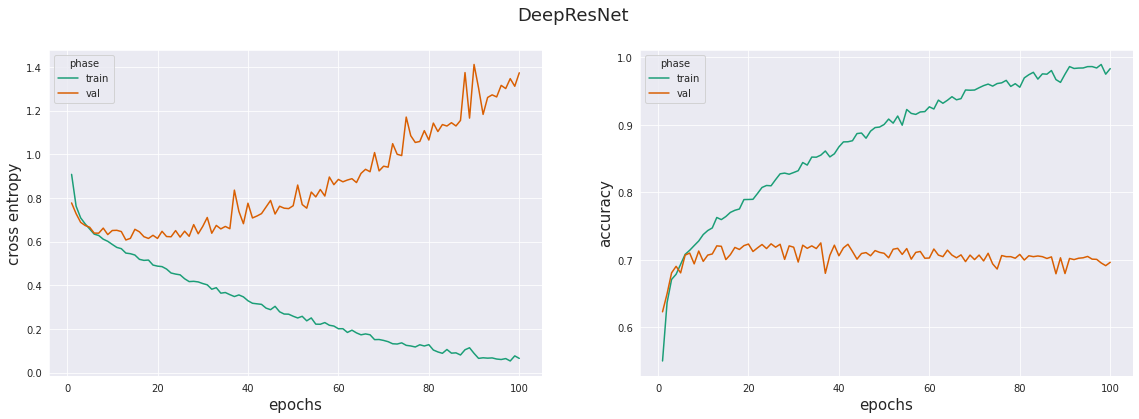

In [32]:
plot_history(log)

In [33]:
models_dict['DeepResNet'] = model, log

### Model comparison

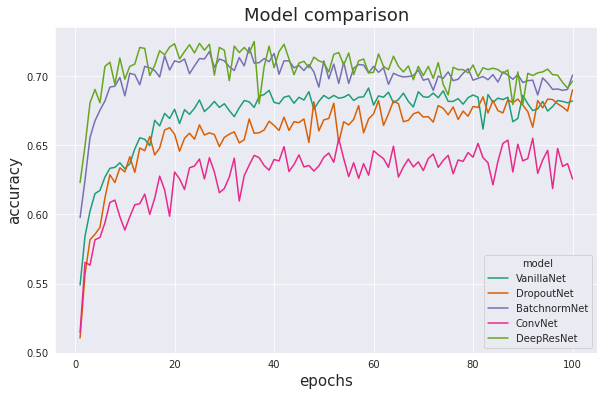

In [34]:
compare_models(models_dict)